In [59]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

## 1. Process Data
### Import Data

In [2]:
df = pd.read_csv(r'data.csv')

### Check the Raw Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451113 entries, 0 to 451112
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ticker  451113 non-null  object 
 1   date    451113 non-null  object 
 2   last    451113 non-null  float64
 3   volume  451113 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 13.8+ MB


In [4]:
price = df.pivot(index='date',columns='ticker',values='last')
vol = df.pivot(index='date',columns='ticker',values='volume')
ret = np.log(price).diff().dropna(how='all')

<AxesSubplot: title={'center': 'Number of Cross-sectional Securities'}, xlabel='date'>

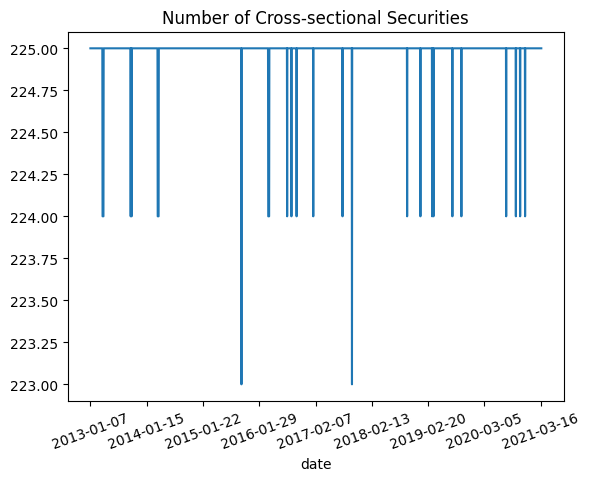

In [5]:
ret.count(axis=1).plot(rot=20,title='Number of Cross-sectional Securities')

#### The number of cross-sectional securities is stable over time.

In [6]:
ret.describe().T

,count,mean,std,min,25%,50%,75%,max
ticker,,,,,,,,
1332 JT,2004.0,0.000604,0.022013,-0.143222,-0.010526,0.000000,0.010855,0.170313
1333 JT,1700.0,0.000317,0.016475,-0.090565,-0.008200,0.000000,0.008553,0.111935
1334 JT,299.0,0.000406,0.018181,-0.070110,-0.010638,0.000000,0.010811,0.078590
1605 JT,2004.0,-0.000099,0.021702,-0.138740,-0.012130,0.000000,0.011564,0.117395
1721 JT,2004.0,0.000644,0.017446,-0.089006,-0.008567,0.000583,0.009653,0.090794
...,...,...,...,...,...,...,...,...
9681 JT,1648.0,0.000357,0.021134,-0.124967,-0.010050,0.000000,0.009954,0.140331
9735 JT,2004.0,0.000473,0.014300,-0.078810,-0.006805,0.000713,0.007976,0.094858
9766 JT,2004.0,0.000689,0.021007,-0.103351,-0.010735,0.000000,0.012286,0.134471


<AxesSubplot: >

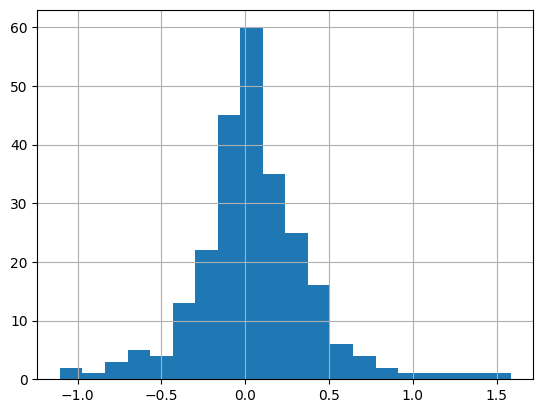

In [7]:
ret.skew().hist(bins=20)

<AxesSubplot: >

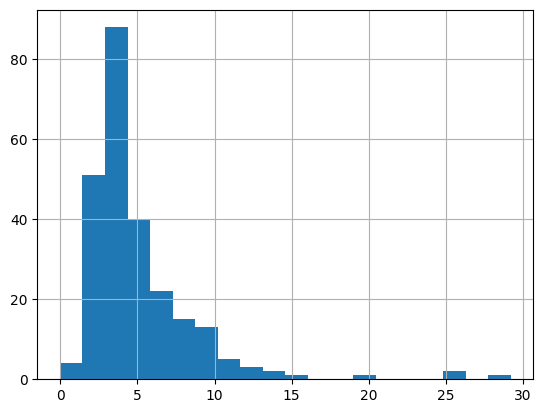

In [8]:
ret.kurtosis().hist(bins=20)

## 2. Strategy Development
### Long-only, daily rebalanced
### Benchmark: EWP
#### Equal Weighted Portfolio:  $$ \bf{w}=1/N $$
### Base Strategy: MDP
#### The Most Diversified Portfolio (MDP) is a risk-based portfolio, which purely relies on the estimation of covariance matrix. The analytical solution is similar to the Maximum Sharpe Ratio Portfolio, replacing the expected returns with corresponding volatility.  $$ \max_{\bf{w}} \frac{\bf{w}^{T}\bf{\sigma}}{\sqrt{\bf{w}^{T}\bf{\Sigma}\bf{w}}} $$
#### $$ s.t. \bf{1}^{T}\bf{w}=1 $$
#### $$ w_{i}\ge0 $$



In [86]:
def obj_fun(x,Sigma):
    return -(x**2).dot(np.sqrt(np.diag(Sigma)))/np.sqrt((x**2).T.dot(Sigma).dot(x**2))

In [91]:
def find_opt_w(Sigma):
    x_ini = np.ones(len(Sigma))/np.sqrt(len(Sigma))
    cons = ({'type':'eq','fun':lambda x:sum(x**2)-1},)
    opt = minimize(obj_fun,x_ini,args=(Sigma,),constraints=cons)
    w_opt = opt.x**2
    return w_opt

In [147]:
def mdp(window_ret):
    window_ret = window_ret.dropna(axis=1)
    Sigma = window_ret.cov()
    w = find_opt_w(Sigma)
    w = pd.Series(data=w,index=Sigma.index)
    return w

## 3. Back Test

In [ ]:
T=100
target_weight = pd.DataFrame()
for i in range(len(ret)-T+1):
    window_ret = ret.iloc[i:i+T]
    # print(window_ret.index[-1])
    weight = mdp(window_ret)
    weight.name = window_ret.index[-1]
    target_weight = pd.concat([target_weight,weight],axis=1)
target_weight = target_weight.T

In [109]:
port_weight = target_weight.shift(1).fillna(0)

In [110]:
selected_ret = ret.loc[port_weight.index,port_weight.columns].fillna(0)

In [111]:
port_ret = np.diag(port_weight.dot(selected_ret.T))
port_ret = pd.Series(data=port_ret,index=port_weight.index)
port_cum_ret = (port_ret+1).cumprod()

<AxesSubplot: >

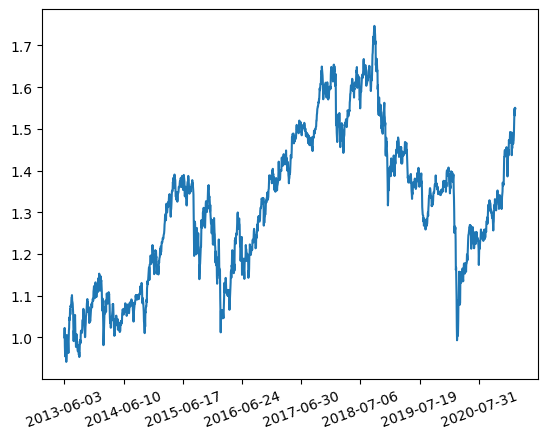

In [112]:
port_cum_ret.plot(rot=20) #T=100

#### Benchmark

<AxesSubplot: >

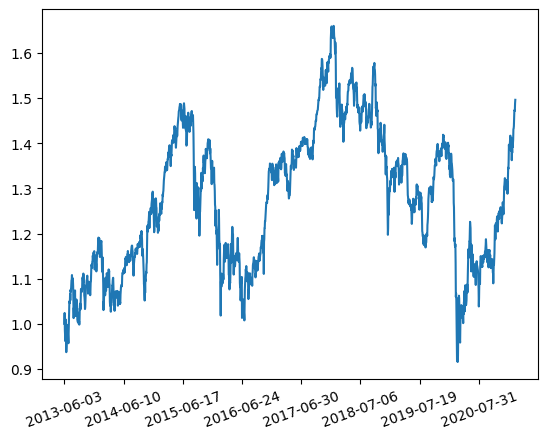

In [113]:
ewp_ret = ret.loc[port_ret.index].mean(axis=1)
ewp_ret.iloc[0] = 0
ewp_cum_ret = (ewp_ret+1).cumprod()
ewp_cum_ret.plot(rot=20)

#### Performance Measures

In [114]:
def performance(ret_series):
    cum_ret = (ret_series+1).cumprod()
    max_drawdown = ((cum_ret.cummax()-cum_ret)/cum_ret.cummax()).max()
    ret_series=ret_series.iloc[1:]
    annualized_ret= ret_series.mean()*245
    annualized_std= ret_series.std()*245**0.5
    sharpe_ratio = annualized_ret/annualized_std
    return {'Return': round(annualized_ret,3),
            'Standard Deviation': round(annualized_std,3),
            'Sharpe Ratio':round(sharpe_ratio,3),
            'Maximum Drawdown':round(max_drawdown,3)}

##### Benchmark

In [115]:
performance(ewp_ret)

{'Return': 0.074,
 'Standard Deviation': 0.21,
 'Sharpe Ratio': 0.352,
 'Maximum Drawdown': 0.448}

##### MDP

In [116]:
performance(port_ret)

{'Return': 0.074,
 'Standard Deviation': 0.188,
 'Sharpe Ratio': 0.394,
 'Maximum Drawdown': 0.432}

### Comments
##### The MDP outperforms benchmark (EWP) in the sense of higher Sharpe Ratio and lower Maximum Drawdown.

## 4. Improvements
### (1) Exponential weighted covariance matrix

In [153]:
def exp_weights(lmd, N):
    return np.array([lmd ** n for n in range(N)][::-1])

def mdp_ewcov(window_ret, lmd):
    window_ret = window_ret.dropna(axis=1)
    Sigma = np.cov(window_ret.T, aweights=exp_weights(lmd, len(window_ret)))
    w = find_opt_w(Sigma)
    w = pd.Series(data=w, index=window_ret.columns)
    return w

In [ ]:
T = 100
lmd = 0.96
target_weight = pd.DataFrame()
for i in range(len(ret) - T + 1):
    window_ret = ret.iloc[i:i + T]
    print(window_ret.index[-1])
    weight = mdp_ewcov(window_ret,lmd)
    weight.name = window_ret.index[-1]
    target_weight = pd.concat([target_weight, weight], axis=1)
target_weight = target_weight.T
port_weight = target_weight.shift(1).fillna(0)
selected_ret = ret.loc[port_weight.index, port_weight.columns].fillna(0)
port_ret = np.diag(port_weight.dot(selected_ret.T))
port_ret = pd.Series(data=port_ret, index=port_weight.index)
port_cum_ret = (port_ret + 1).cumprod()
port_cum_ret.plot(rot=20)

In [155]:
performance(port_ret)

{'Return': 0.102,
 'Standard Deviation': 0.187,
 'Sharpe Ratio': 0.547,
 'Maximum Drawdown': 0.438}

2013-06-03
2013-06-04
2013-06-05
2013-06-06
2013-06-07
2013-06-10
2013-06-11
2013-06-12
2013-06-13
2013-06-14
2013-06-17
2013-06-18
2013-06-19
2013-06-20
2013-06-21
2013-06-24
2013-06-25
2013-06-26
2013-06-27
2013-06-28
2013-07-01
2013-07-02
2013-07-03
2013-07-04
2013-07-05
2013-07-08
2013-07-09
2013-07-10
2013-07-11
2013-07-12
2013-07-16
2013-07-17
2013-07-18
2013-07-19
2013-07-22
2013-07-23
2013-07-24
2013-07-25
2013-07-26
2013-07-29
2013-07-30
2013-07-31
2013-08-01
2013-08-02
2013-08-05
2013-08-06
2013-08-07
2013-08-08
2013-08-09
2013-08-12
2013-08-13
2013-08-14
2013-08-15
2013-08-16
2013-08-19
2013-08-20
2013-08-21
2013-08-22
2013-08-23
2013-08-26
2013-08-27
2013-08-28
2013-08-29
2013-08-30
2013-09-02
2013-09-03
2013-09-04
2013-09-05
2013-09-06
2013-09-09
2013-09-10
2013-09-11
2013-09-12
2013-09-13
2013-09-17
2013-09-18
2013-09-19
2013-09-20
2013-09-24
2013-09-25
2013-09-26
2013-09-27
2013-09-30
2013-10-01
2013-10-02
2013-10-03
2013-10-04
2013-10-07
2013-10-08
2013-10-09
2013-10-10

<AxesSubplot: >

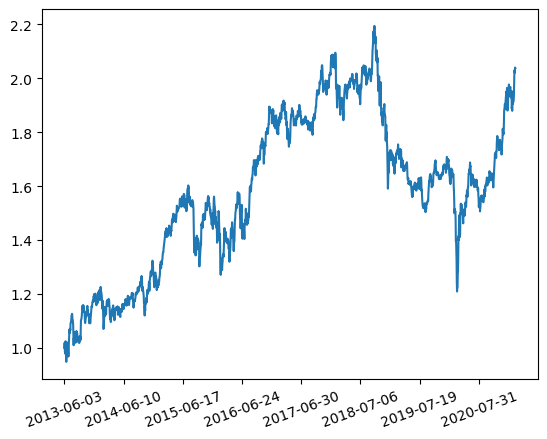

In [156]:
T = 100
lmd = 0.94
target_weight = pd.DataFrame()
for i in range(len(ret) - T + 1):
    window_ret = ret.iloc[i:i + T]
    print(window_ret.index[-1])
    weight = mdp_ewcov(window_ret,lmd)
    weight.name = window_ret.index[-1]
    target_weight = pd.concat([target_weight, weight], axis=1)
target_weight = target_weight.T
port_weight = target_weight.shift(1).fillna(0)
selected_ret = ret.loc[port_weight.index, port_weight.columns].fillna(0)
port_ret = np.diag(port_weight.dot(selected_ret.T))
port_ret = pd.Series(data=port_ret, index=port_weight.index)
port_cum_ret = (port_ret + 1).cumprod()
port_cum_ret.plot(rot=20)

In [157]:
performance(port_ret)

{'Return': 0.109,
 'Standard Deviation': 0.188,
 'Sharpe Ratio': 0.581,
 'Maximum Drawdown': 0.449}

### (2) Shrinked convariance matrix

In [158]:
def shrinked_cov(Sigma, alpha):
    Sigma_T = np.diag(Sigma).mean()*np.eye(len(Sigma))
    return (1-alpha)*Sigma+alpha*Sigma_T

def mdp_ewcov_shrinked(window_ret, lmd, alpha):
    window_ret = window_ret.dropna(axis=1)
    Sigma = np.cov(window_ret.T, aweights=exp_weights(lmd, len(window_ret)))
    Sigma = shrinked_cov(Sigma,alpha)
    w = find_opt_w(Sigma)
    w = pd.Series(data=w, index=window_ret.columns)
    return w

2013-06-03
2013-06-04
2013-06-05
2013-06-06
2013-06-07
2013-06-10
2013-06-11
2013-06-12
2013-06-13
2013-06-14
2013-06-17
2013-06-18
2013-06-19
2013-06-20
2013-06-21
2013-06-24
2013-06-25
2013-06-26
2013-06-27
2013-06-28
2013-07-01
2013-07-02
2013-07-03
2013-07-04
2013-07-05
2013-07-08
2013-07-09
2013-07-10
2013-07-11
2013-07-12
2013-07-16
2013-07-17
2013-07-18
2013-07-19
2013-07-22
2013-07-23
2013-07-24
2013-07-25
2013-07-26
2013-07-29
2013-07-30
2013-07-31
2013-08-01
2013-08-02
2013-08-05
2013-08-06
2013-08-07
2013-08-08
2013-08-09
2013-08-12
2013-08-13
2013-08-14
2013-08-15
2013-08-16
2013-08-19
2013-08-20
2013-08-21
2013-08-22
2013-08-23
2013-08-26
2013-08-27
2013-08-28
2013-08-29
2013-08-30
2013-09-02
2013-09-03
2013-09-04
2013-09-05
2013-09-06
2013-09-09
2013-09-10
2013-09-11
2013-09-12
2013-09-13
2013-09-17
2013-09-18
2013-09-19
2013-09-20
2013-09-24
2013-09-25
2013-09-26
2013-09-27
2013-09-30
2013-10-01
2013-10-02
2013-10-03
2013-10-04
2013-10-07
2013-10-08
2013-10-09
2013-10-10

<AxesSubplot: >

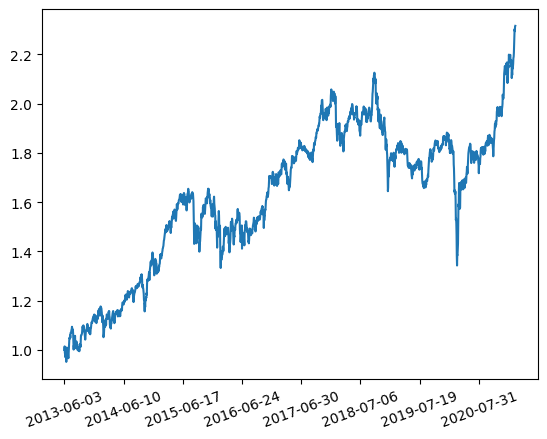

In [162]:
T = 100
lmd = 0.94
alpha = 0.5
target_weight = pd.DataFrame()
for i in range(len(ret) - T + 1):
    window_ret = ret.iloc[i:i + T]
    print(window_ret.index[-1])
    weight = mdp_ewcov_shrinked(window_ret,lmd,alpha)
    weight.name = window_ret.index[-1]
    target_weight = pd.concat([target_weight, weight], axis=1)
target_weight = target_weight.T
port_weight = target_weight.shift(1).fillna(0)
selected_ret = ret.loc[port_weight.index, port_weight.columns].fillna(0)
port_ret = np.diag(port_weight.dot(selected_ret.T))
port_ret = pd.Series(data=port_ret, index=port_weight.index)
port_cum_ret = (port_ret + 1).cumprod()
port_cum_ret.plot(rot=20)

In [164]:
performance(port_ret)

{'Return': 0.122,
 'Standard Deviation': 0.168,
 'Sharpe Ratio': 0.727,
 'Maximum Drawdown': 0.368}

#### Comments
##### The last strategy performs the best at this stage with the advantage of simplicity and transparency. This strategy is not a result of brute-force optimization. Therefore, the risk of over-fitting may be low. Still we can improve it by considering the fat tails in the estimation of covariance matrix, and filtering the stocks before calculating the weighs by testing the predictability of the distribution. But these are at the cost of complexity and computing time.